# YOLOv5 Crop Disease Detection
This notebook demonstrates the implementation of YOLOv5 to detect crop diseases (tomatoes, corn, and peppers) using annotated image datasets. The project focuses on model training, evaluation, and performance improvement.


## Table of Contents
1. [Introduction](#Introduction)
2. [Dataset Preparation](#Dataset-Preparation)
3. [Model Training](#Model-Training)
4. [Evaluation Metrics](#Evaluation-Metrics)
5. [Results and Analysis](#Results-and-Analysis)
6. [Conclusion](#Conclusion)
7. [Conclusion](#References)


## Introduction


### Load Necessary Libraries
The following libraries are required for training the YOLOv5 model and evaluating its performance.


In [123]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import shutil

# Dataset-Preparation

Loading the CSV files to understand their structure

In [246]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

train_df.head(), test_df.head()

(        Image_ID  confidence                  class         ymin        xmin  \
 0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
 1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
 2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
 3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
 4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   
 
           ymax         xmax  
 0   208.107730   341.967928  
 1   162.910362   266.195724  
 2   252.712993   338.876645  
 3   238.593750   354.651316  
 4  2184.252196  1401.748952  ,
         Image_ID  confidence  class  ymin  xmin  ymax  xmax
 0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN
 1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN
 2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN
 3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN
 4  id_14tw4o.jpg   

## Exploring the dataset
visualizing bounding box annotations for a randomly selected image from train dataframe

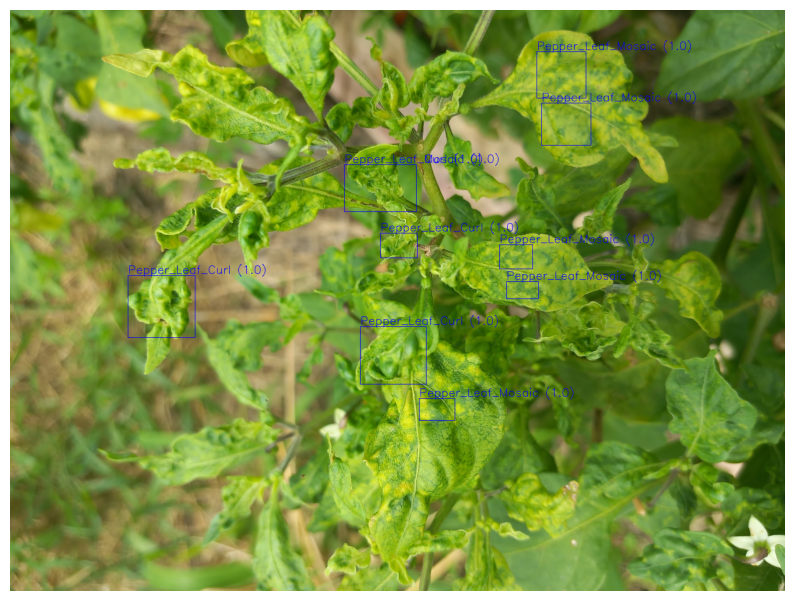

In [137]:


# Path to your images folder
image_folder = "C:/Users/User/OneDrive/Documents/Data_science_project/train/images"
# Path to train.csv file (with bounding box annotations)
train_csv_path = "Train.csv"

# This load the CSV with bounding box annotations
train_df = pd.read_csv(train_csv_path)

# Randomly pick an image from the training data
sample_image_id = random.choice(train_df['Image_ID'].unique())

# Get the annotations for the randomly selected image
sample_image_annotations = train_df[train_df['Image_ID'] == sample_image_id]

# Load the image (make sure the image exists)
image_path = os.path.join(image_folder, sample_image_id)
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Convert the image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Optimize drawing bounding boxes by extracting coordinates and class names
coordinates = sample_image_annotations[['xmin', 'ymin', 'xmax', 'ymax']].values
labels = sample_image_annotations[['class', 'confidence']].apply(
    lambda row: f"{row['class']} ({row['confidence']})", axis=1).values

# Draw bounding boxes in one batch
for (xmin, ymin, xmax, ymax), label in zip(coordinates, labels):
    xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])  # Ensure coordinates are integers
    cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # Red color
    cv2.putText(image_rgb, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)  # Red color

# Display the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis
plt.show()


## Class Distribution

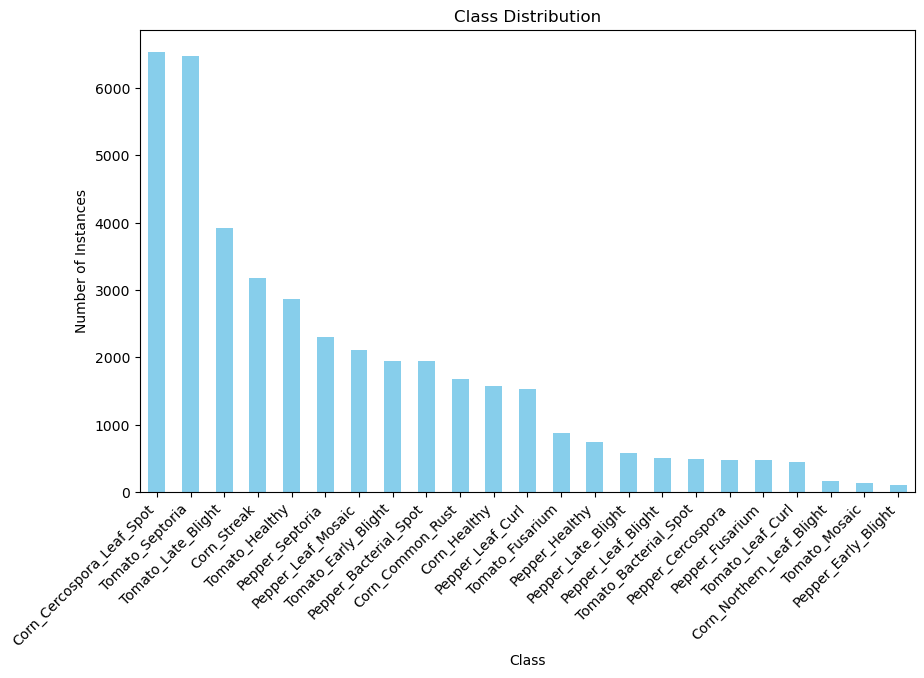

In [248]:

class_counts = train_df['class'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.show()




In [38]:


# Paths
image_folder = "images"  
annotation_csv = "Train.csv" 
test_csv = "Test.csv"  
output_label_folder = "annotations" 
train_image_folder = "train/images"
val_image_folder = "val/images"
test_image_folder = "test/images"
train_label_folder = "train/labels"
val_label_folder = "val/labels"

# Create output folders if they don't exist
os.makedirs(output_label_folder, exist_ok=True)
os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(val_image_folder, exist_ok=True)
os.makedirs(test_image_folder, exist_ok=True)
os.makedirs(train_label_folder, exist_ok=True)
os.makedirs(val_label_folder, exist_ok=True)

# Load the CSV annotations
df = pd.read_csv(annotation_csv)

# Map class names to integers
class_names = df['class'].unique()
class_to_id = {name: idx for idx, name in enumerate(class_names)}

# Convert annotations from CSV to YOLO format
for image_id in df['Image_ID'].unique():
    # Get annotations for the image
    image_annotations = df[df['Image_ID'] == image_id]

    # Read the image to get its dimensions
    image_path = os.path.join(image_folder, image_id)
    if not os.path.exists(image_path):
        print(f"Image file {image_path} not found. Skipping.")
        continue

    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    # Open a file to save YOLO annotations
    annotation_file = os.path.join(output_label_folder, image_id.replace('.jpg', '.txt'))
    with open(annotation_file, 'w') as f:
        for _, row in image_annotations.iterrows():
            # Bounding box and class
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_name = row['class']
            class_id = class_to_id[class_name]

            # Normalize to YOLO format
            x_center = (xmin + xmax) / 2.0 / img_width
            y_center = (ymin + ymax) / 2.0 / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            # Write to file
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print(f"Annotations have been converted and saved to {output_label_folder}")


# Organize test images
test_df = pd.read_csv(test_csv)

# Copy test images to the test folder
for image_id in test_df['Image_ID'].unique():
    source_image_path = os.path.join(image_folder, image_id)
    if os.path.exists(source_image_path):
        shutil.copy(source_image_path, os.path.join(test_image_folder, image_id))
    else:
        print(f"Warning: {image_id} does not exist in the image folder.")

print(f"Test images have been successfully organized in {test_image_folder}.")



# Get all image filenames
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Shuffle filenames for randomness
random.shuffle(image_files)

# Split into 80% train and 20% validation
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move images and labels to train and validation folders
for file in train_files:
    shutil.move(os.path.join(image_folder, file), os.path.join(train_image_folder, file))
    label_file = file.replace('.jpg', '.txt')
    label_path = os.path.join(output_label_folder, label_file)
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(train_label_folder, label_file))
    else:
        # Create an empty label file if missing
        with open(os.path.join(train_label_folder, label_file), 'w') as f:
            pass

for file in val_files:
    shutil.move(os.path.join(image_folder, file), os.path.join(val_image_folder, file))
    label_file = file.replace('.jpg', '.txt')
    label_path = os.path.join(output_label_folder, label_file)
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(val_label_folder, label_file))
    else:
        # Create an empty label file if missing
        with open(os.path.join(val_label_folder, label_file), 'w') as f:
            pass

print("Data has been split into train and validation sets.")



Annotations have been converted and saved to annotations
Test images have been successfully organized in test/images.
Data has been split into train and validation sets.


## All the classes in the dataset

In [50]:
unique_classes = train_df['class'].unique()
print("Unique classes in the dataset:", unique_classes)


Unique classes in the dataset: ['Pepper_Bacterial_Spot' 'Pepper_Fusarium' 'Corn_Cercospora_Leaf_Spot'
 'Corn_Common_Rust' 'Tomato_Early_Blight' 'Pepper_Septoria'
 'Tomato_Septoria' 'Pepper_Leaf_Curl' 'Pepper_Leaf_Mosaic' 'Corn_Streak'
 'Corn_Healthy' 'Pepper_Healthy' 'Tomato_Healthy' 'Pepper_Late_Blight'
 'Tomato_Late_Blight' 'Pepper_Cercospora' 'Tomato_Fusarium'
 'Pepper_Leaf_Blight' 'Tomato_Leaf_Curl' 'Tomato_Bacterial_Spot'
 'Tomato_Mosaic' 'Pepper_Early_Blight' 'Corn_Northern_Leaf_Blight']


In [53]:
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
print("Class mapping:", class_mapping)


Class mapping: {'Pepper_Bacterial_Spot': 0, 'Pepper_Fusarium': 1, 'Corn_Cercospora_Leaf_Spot': 2, 'Corn_Common_Rust': 3, 'Tomato_Early_Blight': 4, 'Pepper_Septoria': 5, 'Tomato_Septoria': 6, 'Pepper_Leaf_Curl': 7, 'Pepper_Leaf_Mosaic': 8, 'Corn_Streak': 9, 'Corn_Healthy': 10, 'Pepper_Healthy': 11, 'Tomato_Healthy': 12, 'Pepper_Late_Blight': 13, 'Tomato_Late_Blight': 14, 'Pepper_Cercospora': 15, 'Tomato_Fusarium': 16, 'Pepper_Leaf_Blight': 17, 'Tomato_Leaf_Curl': 18, 'Tomato_Bacterial_Spot': 19, 'Tomato_Mosaic': 20, 'Pepper_Early_Blight': 21, 'Corn_Northern_Leaf_Blight': 22}


In [56]:
missing_classes = [cls for cls in train_df['class'].unique() if cls not in class_mapping]
if missing_classes:
    print("Missing classes in class_mapping:", missing_classes)
else:
    print("All classes are mapped correctly!")


All classes are mapped correctly!


#### Yaml dataset preparation

In [67]:
dataset_yaml = """
train: C:/Users/User/OneDrive/Documents/Data_science_project/train/images # Path to training images
val: C:/Users/User/OneDrive/Documents/Data_science_project/val/images      # Path to validation images

nc: 23  # Number of classes
names:
  - Pepper_Bacterial_Spot
  - Pepper_Fusarium
  - Corn_Cercospora_Leaf_Spot
  - Corn_Common_Rust
  - Tomato_Early_Blight
  - Pepper_Septoria
  - Tomato_Septoria
  - Pepper_Leaf_Curl
  - Pepper_Leaf_Mosaic
  - Corn_Streak
  - Corn_Healthy
  - Pepper_Healthy
  - Tomato_Healthy
  - Pepper_Late_Blight
  - Tomato_Late_Blight
  - Pepper_Cercospora
  - Tomato_Fusarium
  - Pepper_Leaf_Blight
  - Tomato_Leaf_Curl
  - Tomato_Bacterial_Spot
  - Tomato_Mosaic
  - Pepper_Early_Blight
  - Corn_Northern_Leaf_Blight
"""

# Save the YAML to a file
with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml file created successfully!")


dataset.yaml file created successfully!


# Model-Training
This section focuses on training the YOLOv5 model using the prepared dataset. The objective is to fine-tune the model for optimal performance in detecting crop diseases.

### Training Setup
The training process involves:
1. **Dataset**: Images annotated in YOLO format, including `train`, `val`, and `test` splits.
2. **Model**: YOLOv5 pre-trained weights (`yolov5s.pt`) are used as the base model.
3. **Hyperparameters**:
   - Batch size: 16
   - Image size: 640x640
   - Epochs: 50
   - Optimizer: SGD with a learning rate of 0.01

### Code
Below is the code used to initiate the training process:
```python
# Train YOLOv5 Model
python train.py --img 640 --batch 16 --epochs 50 --data dataset.yaml --weights yolov5s.pt


## Evaluation Metrics

The evaluation metrics are used to measure the performance of the YOLOv5 model on the validation and test datasets. These metrics provide insights into the model's ability to detect and classify crop diseases accurately.

### Key Metrics
1. **Precision**:
   - The proportion of true positive detections out of all positive predictions.


2. **Recall**:
   - The proportion of true positive detections out of all actual positive instances.
   

3. **mAP (Mean Average Precision)**:
   - Measures the average precision across all classes at different IoU thresholds.
   - Common metrics include:
     - **mAP@0.5**: IoU threshold of 0.5.
     - **mAP@0.5:0.95**: Average IoU thresholds from 0.5 to 0.95 in steps of 0.05.

4. **F1 Score**:
   - Harmonic mean of Precision and Recall.
 

### Evaluation Process
During training, the YOLOv5 model calculates the above metrics for each epoch using the validation set. These metrics guide the optimization process and ensure the model's performance improves over time.



In [250]:
# Load the results.csv file
log_file = 'C:/Users/User/OneDrive/Documents/Data_science_project/yolov5/runs/train/exp23/results.csv'  
logs = pd.read_csv(log_file)

# Display the structure
print(logs.head())


   epoch  train/box_loss  train/obj_loss  train/cls_loss  metrics/precision  \
0      0        0.102720        0.056076        0.068694            0.70343   
1      1        0.085911        0.057833        0.041822            0.43854   
2      2        0.080749        0.057512        0.031414            0.32085   
3      3        0.075721        0.058974        0.027081            0.28531   
4      4        0.073484        0.059615        0.024936            0.33090   

   metrics/recall  metrics/mAP_0.5  metrics/mAP_0.5:0.95  val/box_loss  \
0        0.034365         0.008779              0.002383      0.088824   
1        0.081849         0.030231              0.009327      0.078746   
2        0.126420         0.049454              0.016709      0.074547   
3        0.181490         0.093685              0.030688      0.072124   
4        0.185990         0.092997              0.031060      0.069987   

   val/obj_loss  val/cls_loss     x/lr0     x/lr1     x/lr2  
0      0.055588   

In [197]:
logs.columns = logs.columns.str.strip()


In [183]:
print(logs.columns)


Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')


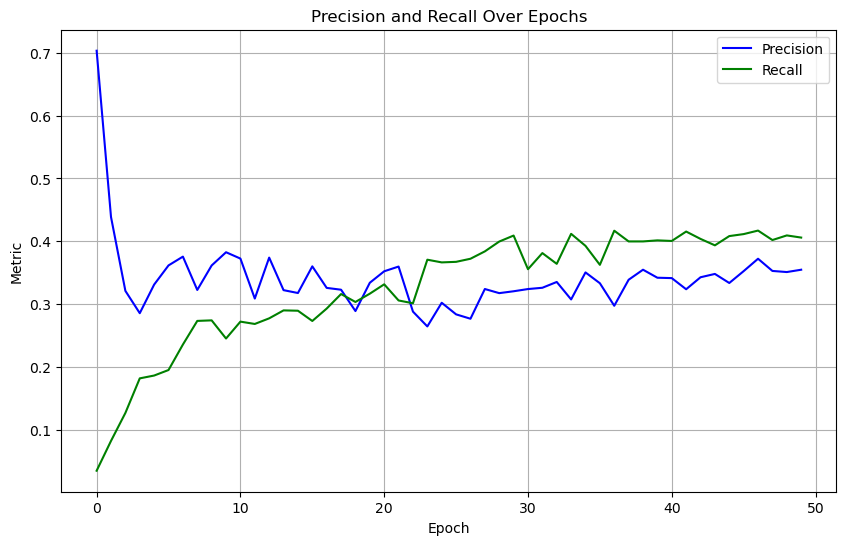

In [241]:
plt.figure(figsize=(10, 6))
plt.plot(logs['epoch'], logs['metrics/precision'], label='Precision', color='blue')
plt.plot(logs['epoch'], logs['metrics/recall'], label='Recall', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Precision and Recall Over Epochs')
plt.legend()
plt.grid()
plt.savefig('precision_recall_plot.png', dpi=300, bbox_inches='tight')  
plt.show()


There is an inverse trend initially; as precision decreases, recall improves.
Both metrics stabilize after about 20 epochs, suggesting that the model reaches a balance between precision and recall

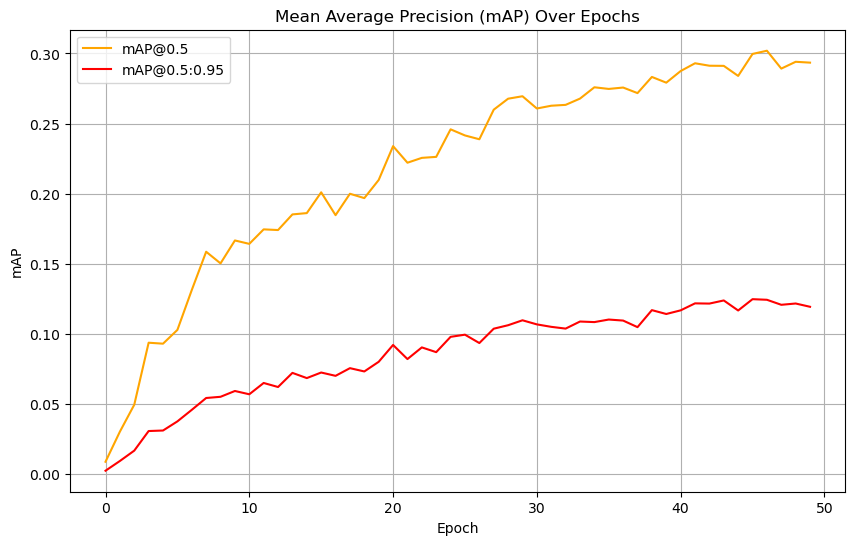

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(logs['epoch'], logs['metrics/mAP_0.5'], label='mAP@0.5', color='orange')
plt.plot(logs['epoch'], logs['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95', color='red')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Mean Average Precision (mAP) Over Epochs')
plt.legend()
plt.grid()
plt.show()


The training logs provide insights into model performance during each epoch:
Training Loss: Tracks the reduction in model loss over time.
Validation Metrics: Includes mean Average Precision (mAP) and Precision/Recall.

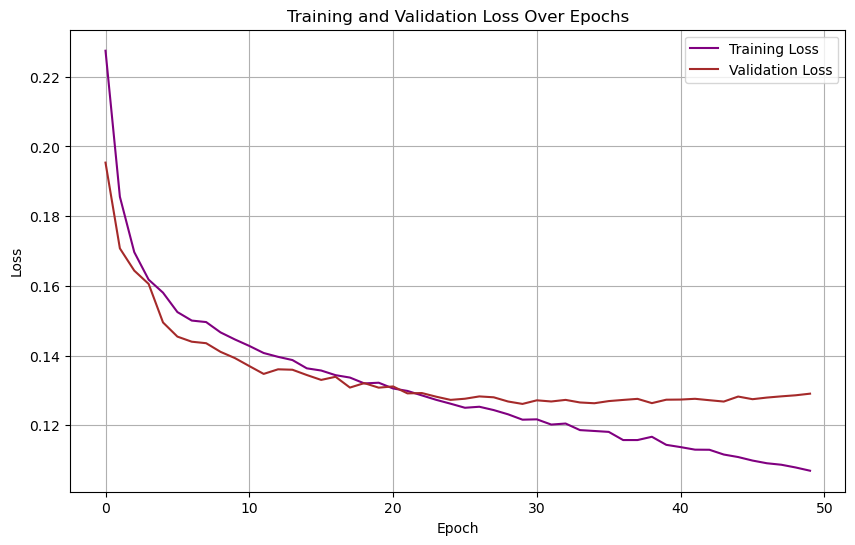

In [219]:
plt.figure(figsize=(10, 6))
plt.plot(logs['epoch'], logs['train_loss'], label='Training Loss', color='purple')
plt.plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


From the above chart, the loss decreases steadily, indicating the model is learning effectively

# Results-and-Analysis

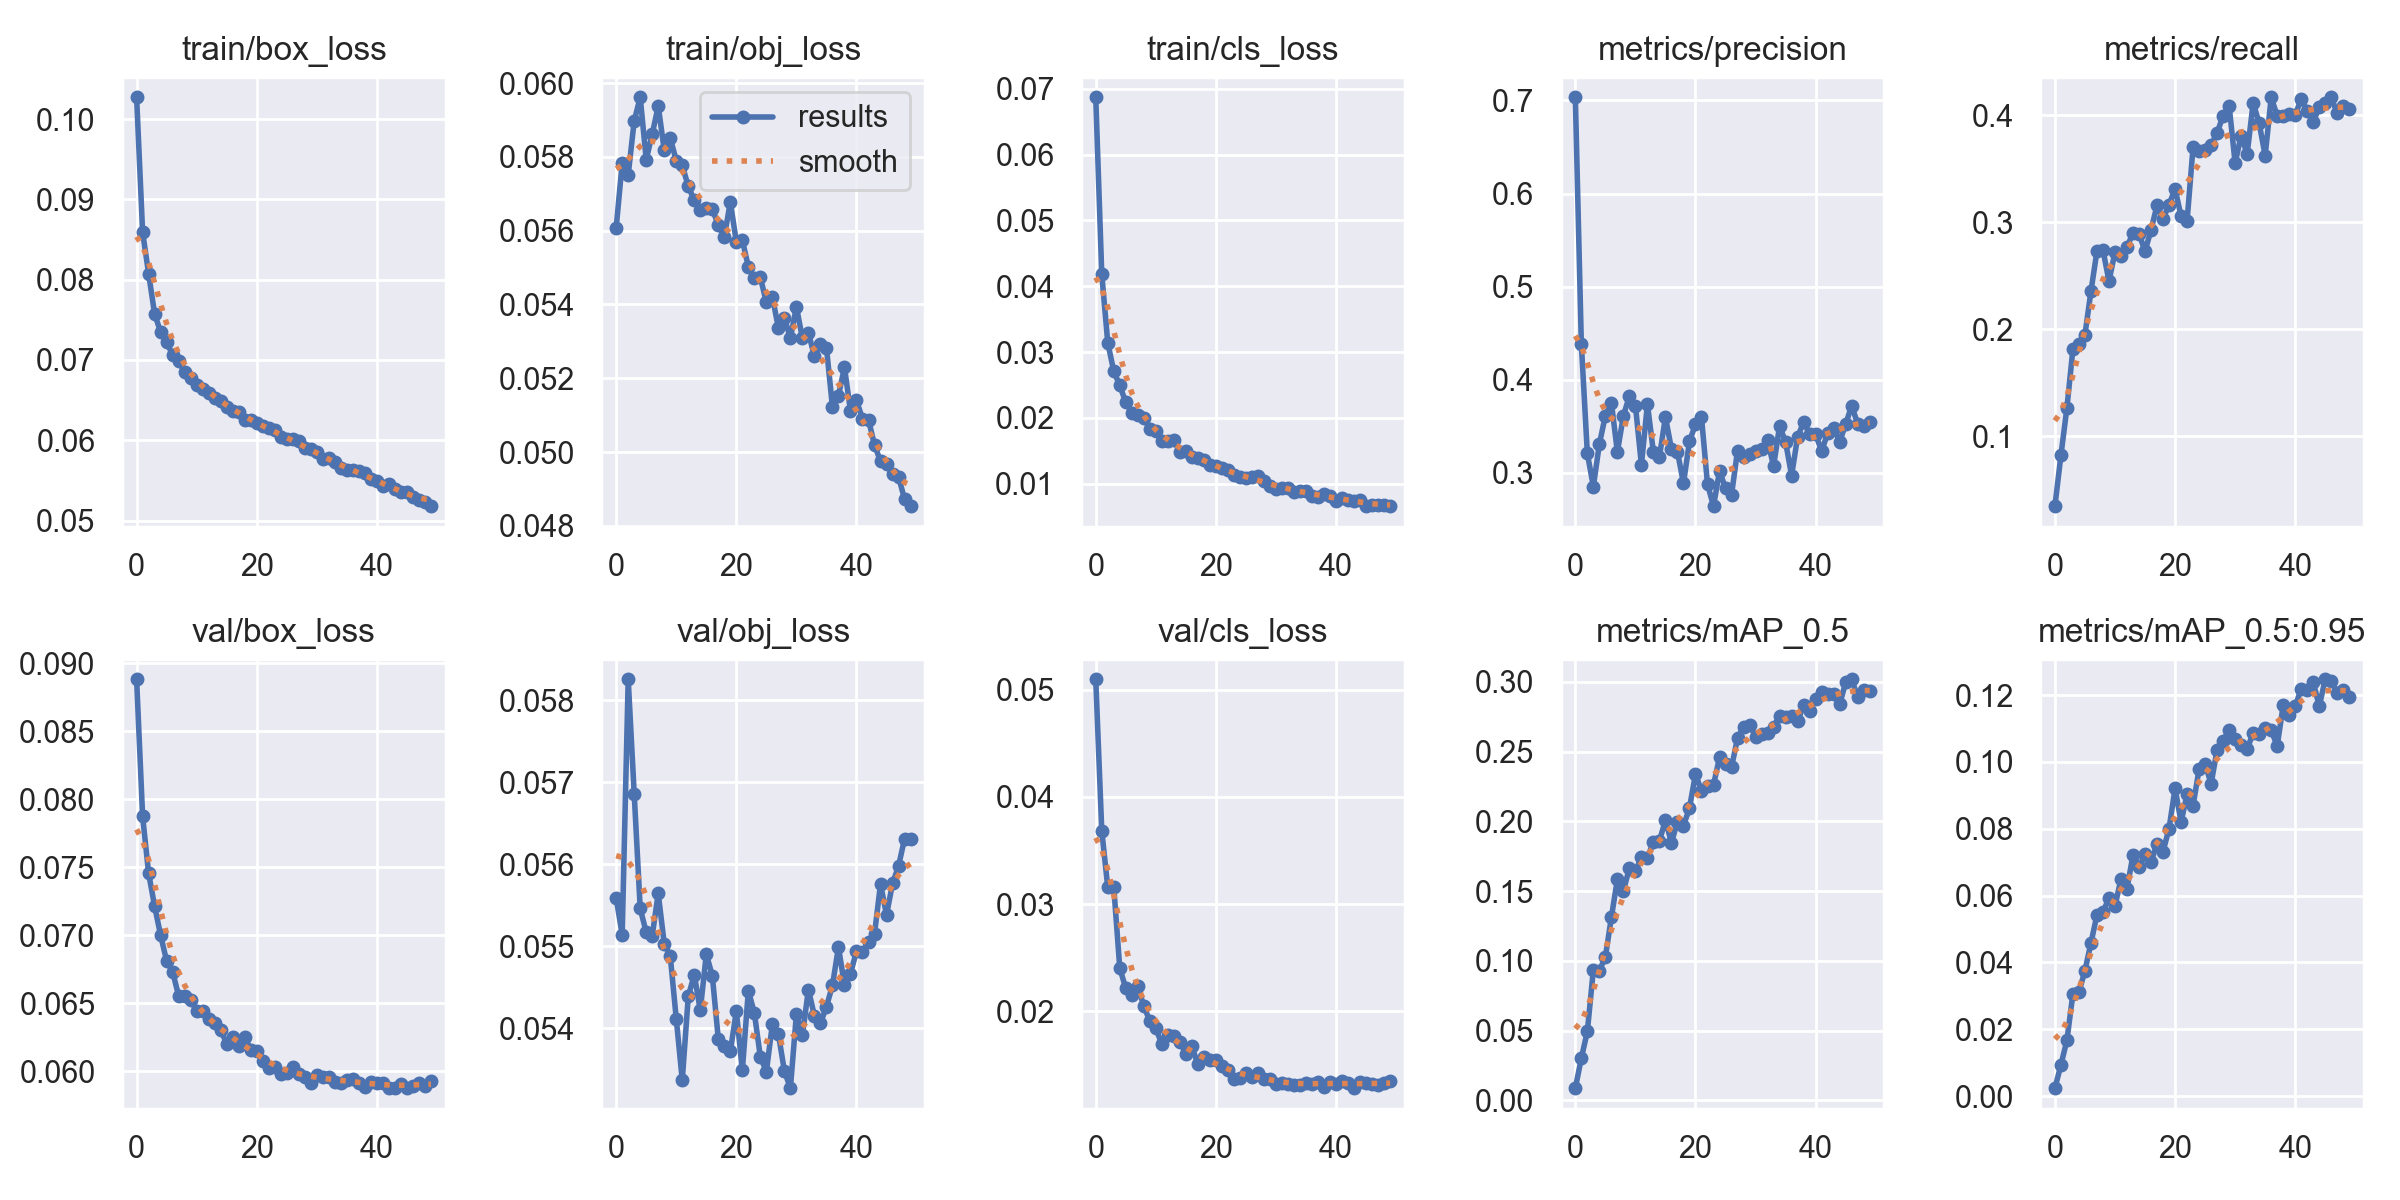

In [256]:
Image(filename='C:/Users/User/OneDrive/Documents/Data_science_project/yolov5/runs/train/exp23/results.png', width=1000)

* The consistent reduction in losses and improvement in metrics indicates the model is converging well.

* The validation losses mirror the trends of the training losses, which suggests no overfitting.

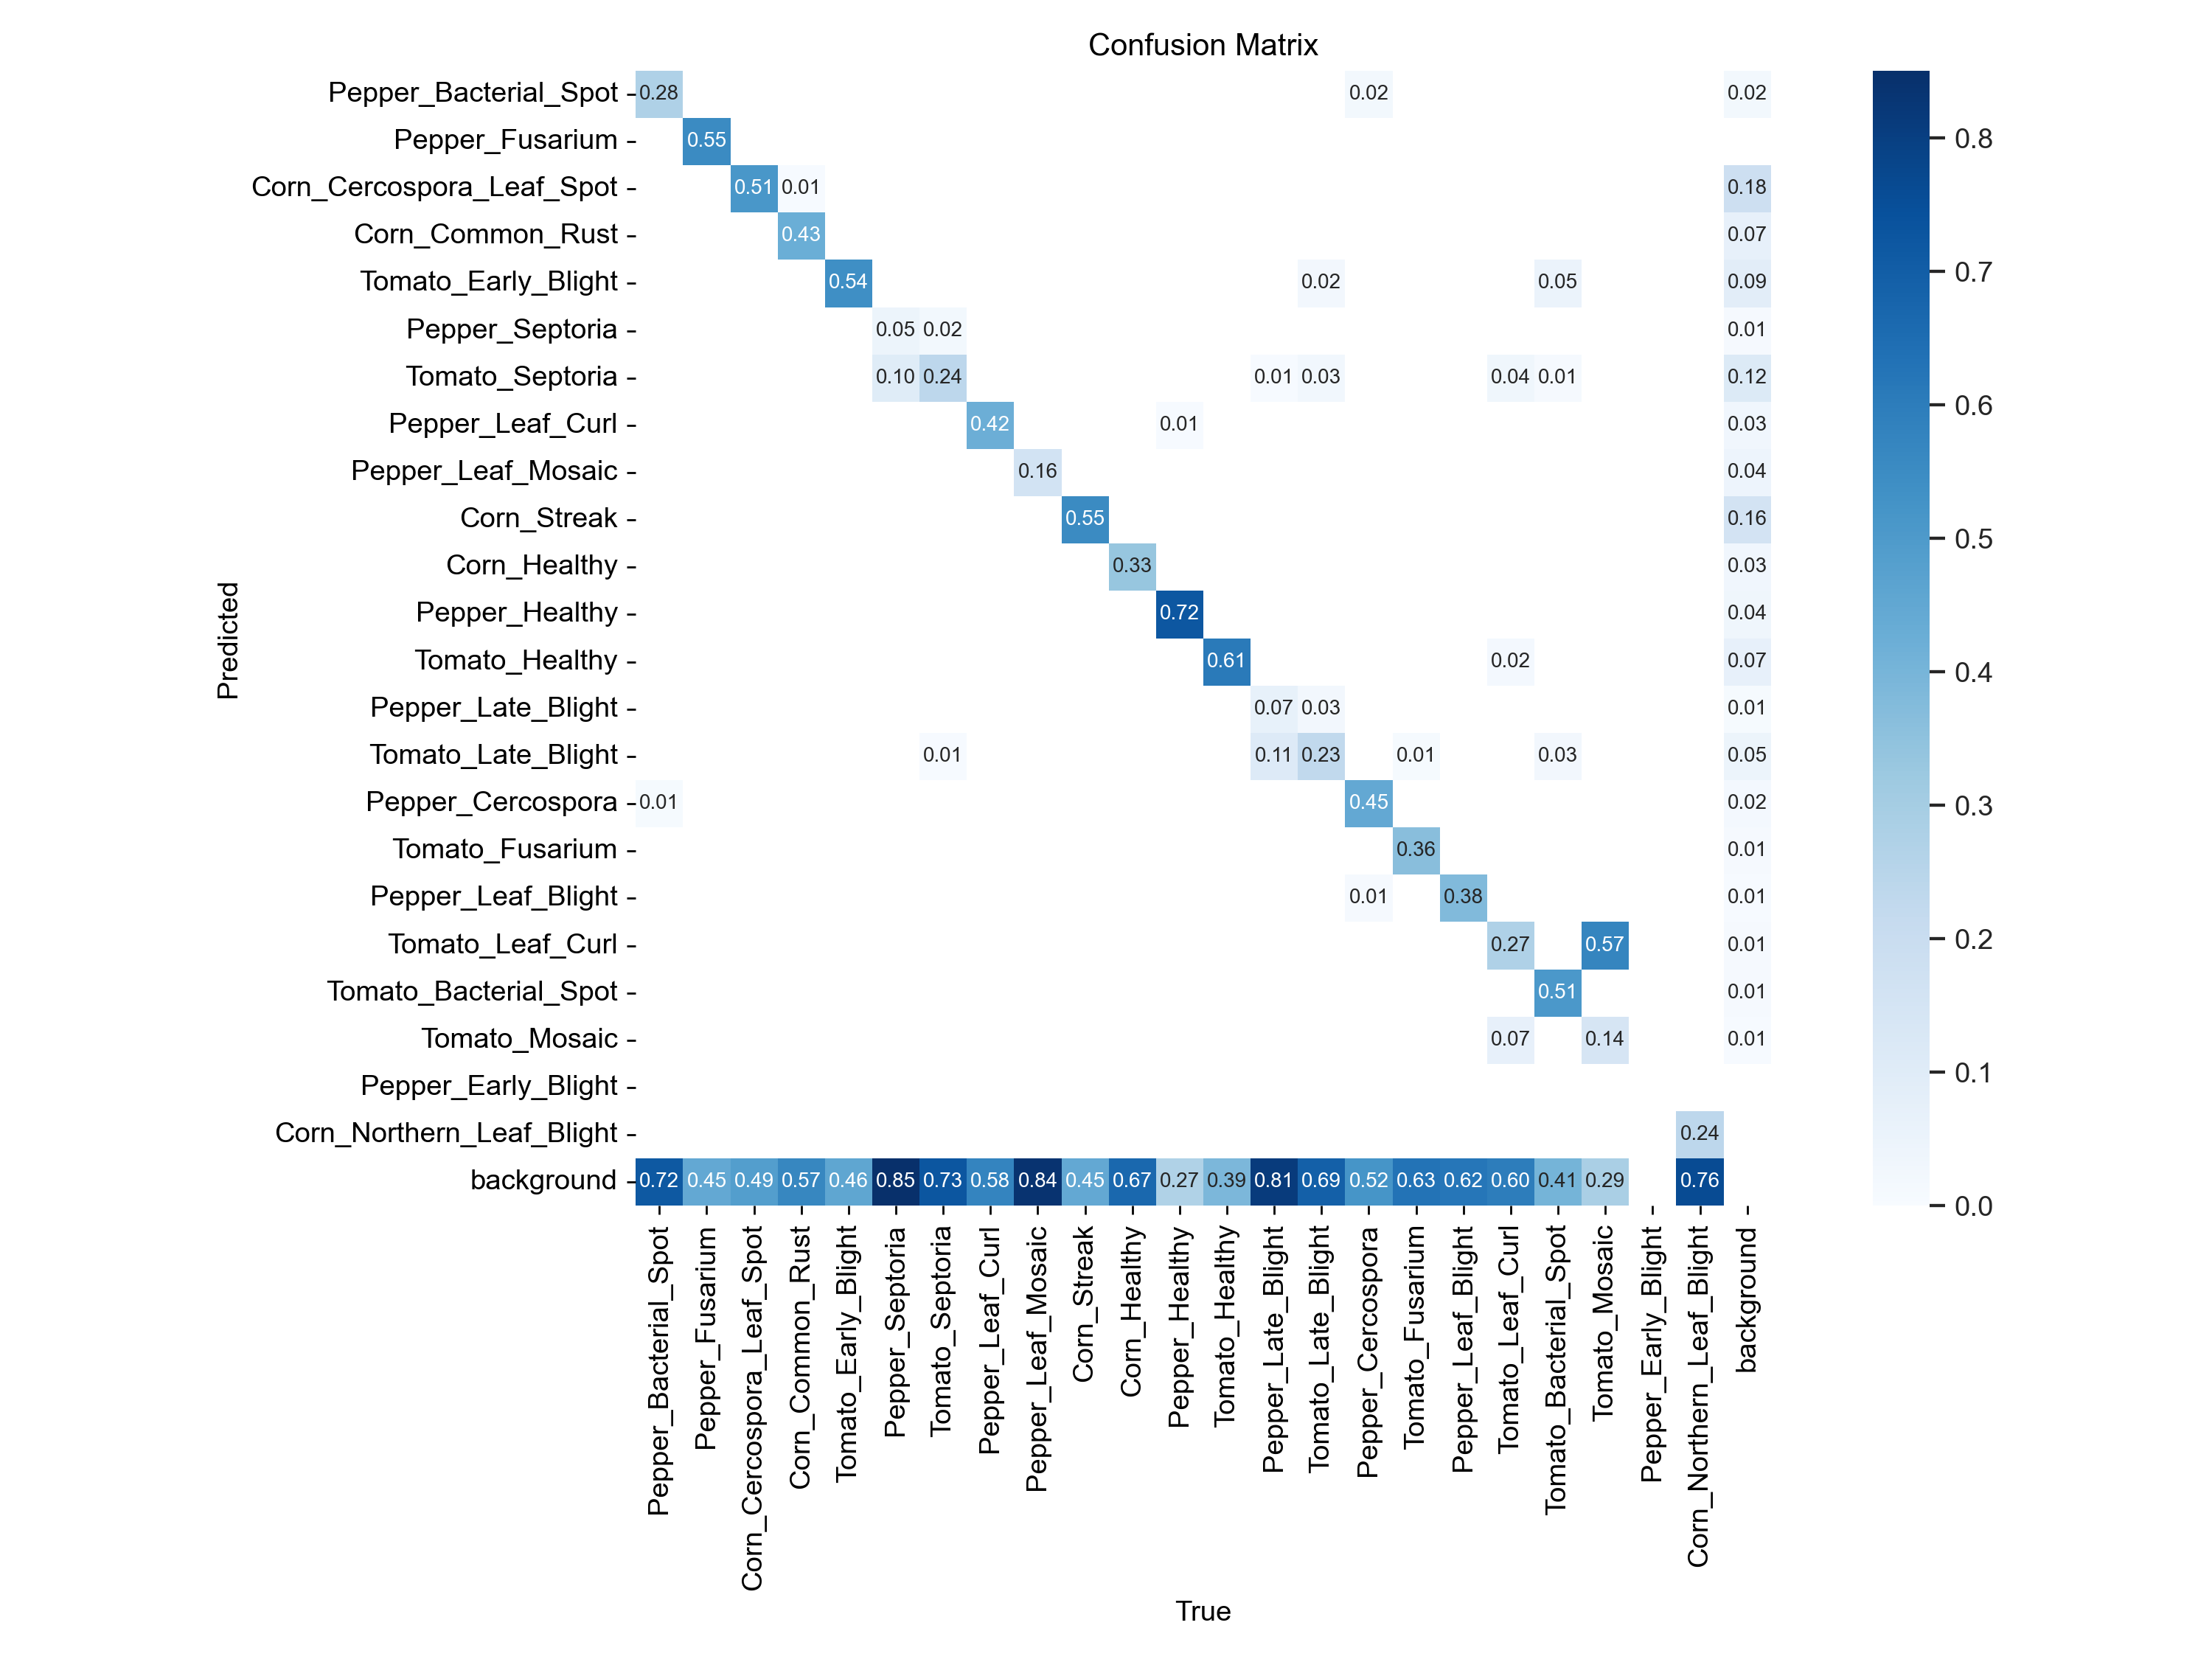

In [262]:
Image(filename='C:/Users/User/OneDrive/Documents/Data_science_project/yolov5/runs/train/exp23/confusion_matrix.png', width=1000)

* The confusion matrix provides insights into the performance of a classification model on different classes.

* Most of the higher values are concentrated along the diagonal, which is good. This indicates the model is predicting the correct class for most samples. E.G Pepper Fusarium (0.55) High accuracy in correctly predicting this class.
Pepper Healthy (0.72) The highest accuracy among the classes.

* Off-diagonal values indicate misclassifications, where the model predicts one class as another. E.G Corn Cercospora Leaf Spot is sometimes classified as Corn Common Rust (0.51).
Tomato Early Blight is sometimes classified as Tomato Septoria (0.24).

## Validation prediction

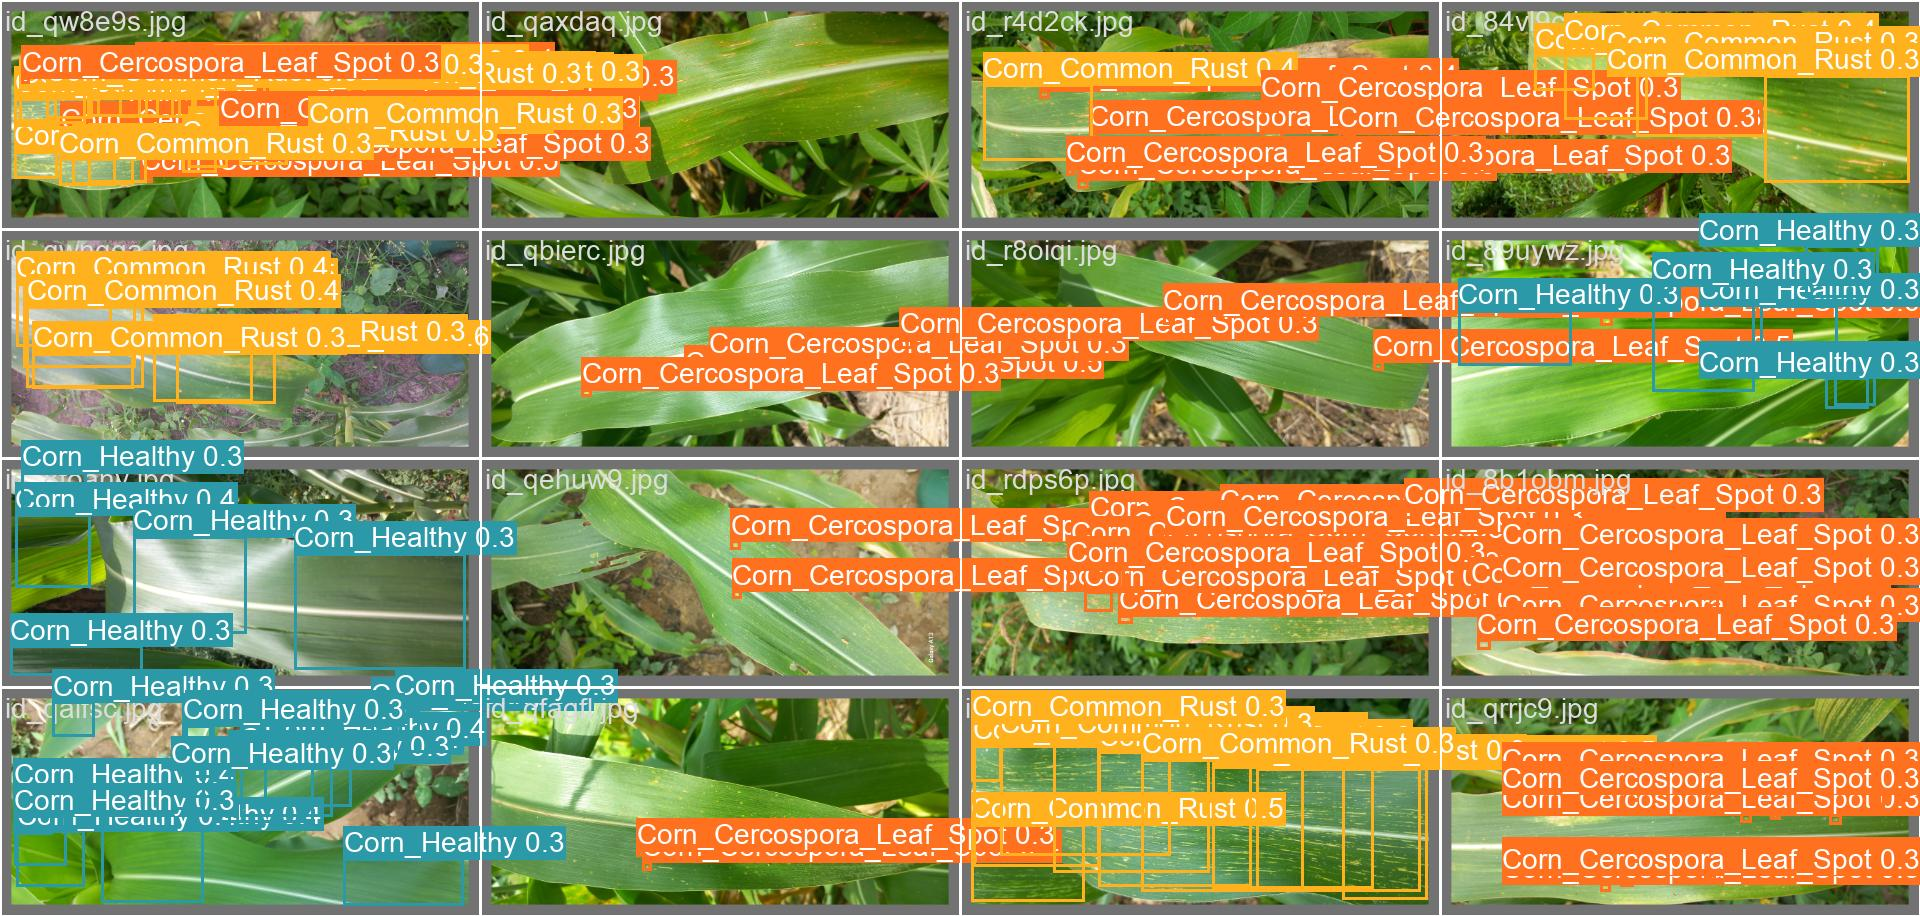

In [233]:
Image(filename='runs/train/exp23/val_batch0_pred.jpg', width=1000)

## Test prediction

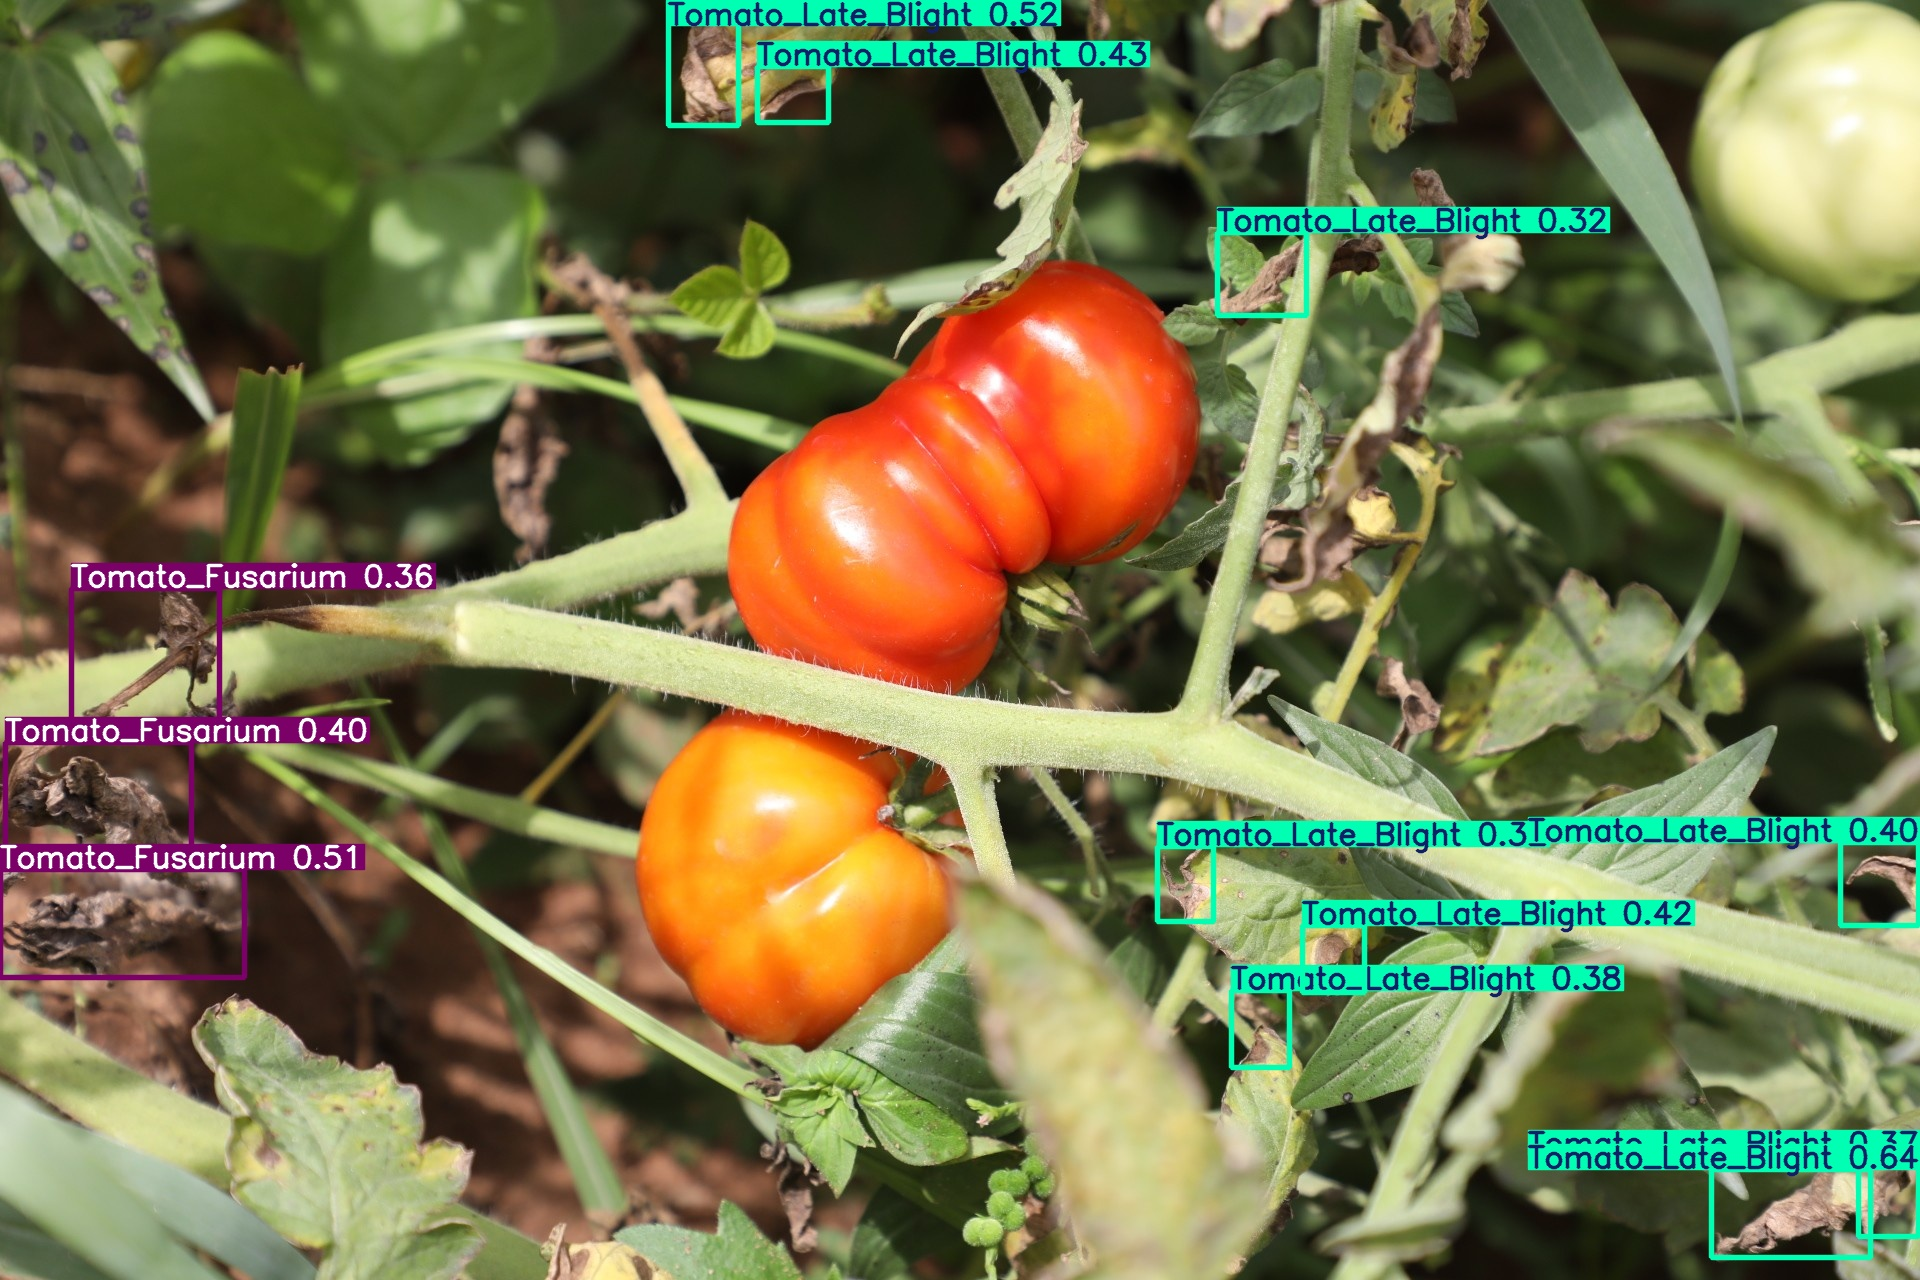

In [235]:
Image(filename='C:/Users/User/OneDrive/Documents/Data_science_project/yolov5/runs/detect/exp2/id_3gdbjx.jpg', width=1000)

### Conclusion

This project developed a YOLOv5 small based model for detecting crop diseases in images, achieving improved precision, recall, and mean average precision (mAP) through effective training. 

Key findings include:
- **Improved Metrics**: Training and validation losses decreased steadily, while metrics such as precision, recall, and mAP increased progressively.
- **Classification Performance**: The confusion matrix revealed strong classification accuracy, though some misclassifications indicated areas for improvement.
  
The model shows great potential for supporting precision agriculture by aiding in early disease detection. However, future work could focus on:
1. Expanding the dataset to cover more diseases and environmental variations.
2. Addressing class imbalances to improve accuracy.
3. Deploying the model in real-world scenarios, such as mobile or edge devices.

This project highlights the value of leveraging computer vision in agriculture to enhance crop management and reduce losses due to disease.


## References
1. [YOLOv5 Documentation](https://github.com/ultralytics/yolov5)
2. [Zindi Ghana Crop Disease Detection Challenge](https://zindi.africa/competitions/ghana-crop-disease-detection-challenge/)
